In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-28 08:22:08.806377: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-28 08:22:08.908556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-28 08:22:08.908594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-28 08:22:08.921657: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-28 08:22:08.951928: I tensorflow/core/platform/cpu_feature_guar

# test on single

In [3]:
tag_params = '_p5_n10000'
idx_LH = 0

# change this directory path as needed
#dir_mocks = f'/cosmos_storage/simulations/BaccoSims/muchisimocks/muchisimocks_lib{tag_params}'
dir_mocks = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib{tag_params}'
subdir_prefix = 'LH'
fn_fields = f'{dir_mocks}/{subdir_prefix}{idx_LH}/bias_fields_eul_deconvolved_{idx_LH}.npy'
bias_terms_eul = np.load(fn_fields)


In [4]:
#the order is b1, b2, bs2, blaplacian
#bias_params = [1, 0, 0, 0]
bias_params = [1.2, 0.5, 0.25, 5]

# use 512 for normalization, because this is the original resolution of the mocks (they were downsampled to 128)
# this doesn't matter for visualization, but will when you go to compute statistics
n_grid_orig = 512
tracer_field = utils.get_tracer_field(bias_terms_eul, bias_params, n_grid_norm=n_grid_orig)

In [5]:
box_size = 1000 # Mpc/h
n_grid = 128 

In [6]:
params_df, param_dict_fixed = data_loader.load_cosmo_params(tag_params)
print(params_df)
param_dict = params_df.loc[idx_LH].to_dict()
cosmo = utils.get_cosmo(param_dict)

      omega_cold  sigma8_cold    hubble  omega_baryon        ns
0       0.236617     0.697564  0.663683      0.048591  0.957079
1       0.337168     0.793531  0.602884      0.052822  0.959740
2       0.285414     0.852452  0.730887      0.053568  0.969280
3       0.238496     0.686086  0.714819      0.050500  0.967325
4       0.274884     0.893641  0.600121      0.057412  0.981679
...          ...          ...       ...           ...       ...
9995    0.281629     0.682273  0.783502      0.051098  0.951428
9996    0.310038     0.842970  0.706149      0.053284  0.979408
9997    0.299789     0.865812  0.676875      0.057476  0.938394
9998    0.351611     0.858341  0.704226      0.045547  0.963179
9999    0.341659     0.786988  0.708020      0.054471  0.924276

[10000 rows x 5 columns]


In [7]:
matter_density_field = bias_terms_eul[1]
pgm_obj = cs.compute_pgm(tracer_field, matter_density_field, cosmo, box_size, n_grid_orig)

Computing pgm, using n_grid =  128


2026-01-28 08:22:42,377 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-28 08:22:42,954 bacco.statistics :  ...done in 0.577 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 6.31307e-11 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002925 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.079306 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000124 secs
bacco.power : Deallocating arrays


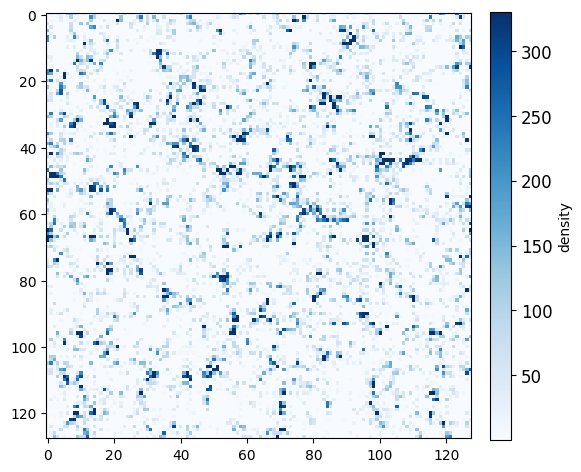

In [8]:
plotter.plot_field(matter_density_field, overdensity=False)

In [9]:
pk_obj = cs.compute_pk(tracer_field, cosmo, box_size, n_grid_orig)

Computing pk, using n_grid =  128


2026-01-28 08:22:47,650 bacco.statistics : Computing the power spectrum with ngrid=128 and interlacing=False
2026-01-28 08:22:47,688 bacco.statistics :  ...done in 0.0383 s


bacco.power : boxsize 1000.000000; ngrid 128; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 1 (grid1) 1 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.002156 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023548 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000157 secs
bacco.power : Deallocating arrays


/tmp/ipykernel_1390314/847835007.py:15: RuntimeWarning: invalid value encountered in divide
  frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']


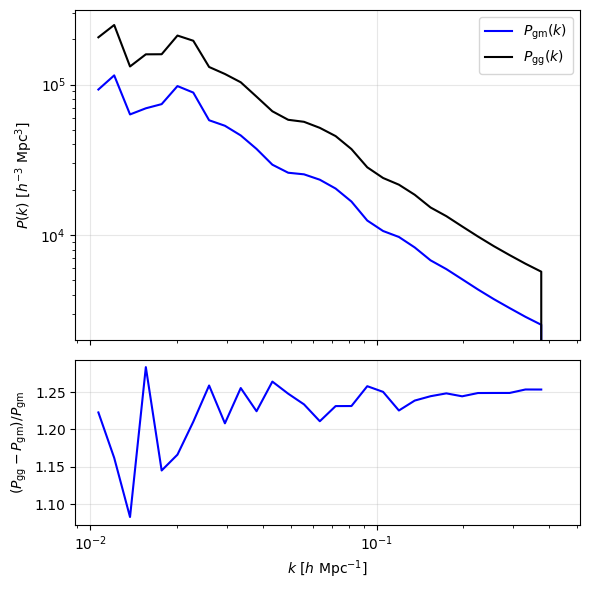

In [10]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Upper panel: power spectra
ax1.plot(pgm_obj['k'], pgm_obj['pk'], label=r'$P_{\rm gm}(k)$', color='blue')
ax1.plot(pk_obj['k'], pk_obj['pk'], label=r'$P_{\rm gg}(k)$', color='k')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylabel(r'$P(k) \,\, [h^{-3} \,\, {\rm Mpc}^3]$')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Lower panel: fractional difference
# Assume k bins are the same
frac_diff = (pk_obj['pk'] - pgm_obj['pk']) / pgm_obj['pk']

ax2.plot(pgm_obj['k'], frac_diff, color='blue', linewidth=1.5)
#ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
ax2.set_xscale('log')
ax2.set_xlabel(r'$k \,\, [h \,\, {\rm Mpc}^{-1}]$')
ax2.set_ylabel(r'$(P_{\rm gg} - P_{\rm gm}) / P_{\rm gm}$')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# shame

In [11]:
from process_catalogs import round_to_nearest_even

In [12]:
data_mode = 'shame'
cosmo = utils.get_cosmo(utils.cosmo_dict_shame)
box_size_mock = 1024.0
box_size_muchisimocks = 1000.0
n_grid_orig = 512
n_grid = 128
n_grid_orig_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid_orig))
n_grid_mock = round_to_nearest_even(box_size_mock / (box_size_muchisimocks/n_grid))
print(n_grid_orig_mock)

524


In [13]:
tag_mock = '_nbar0.00022'
fn_cat0_mesh = f'../data/data_{data_mode}/data{tag_mock}/tracer_field_phase0.npy'
tracer_field0 = np.load(fn_cat0_mesh)
print(tracer_field0.shape)

(132, 132, 132)


In [14]:
#dens_field0 = dens_field0_kcut_deconvolved
fn_dens0_mesh = f'../data/data_{data_mode}/dens_mesh_phase0.npy'
dens_field0 = np.load(fn_dens0_mesh)
print(dens_field0.shape)

(132, 132, 132)


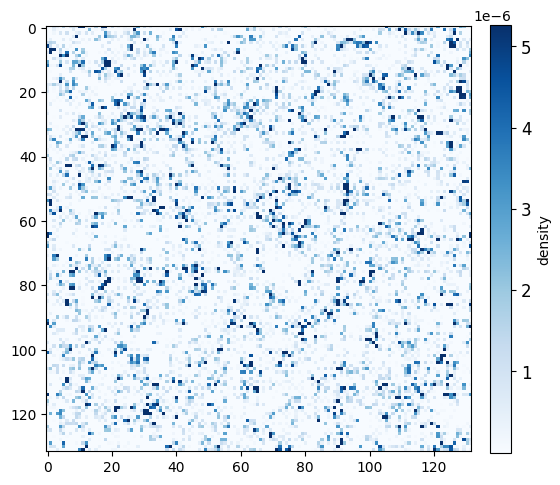

In [15]:
plotter.plot_field(tracer_field0, overdensity=False)

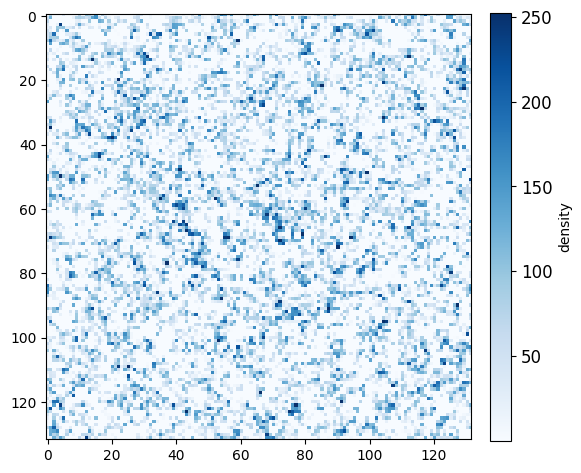

In [16]:
plotter.plot_field(dens_field0, overdensity=False)

In [17]:
pgm_obj_shame = cs.compute_pgm(tracer_field0, dens_field0, cosmo, box_size_mock, n_grid_orig_mock)

Computing pgm, using n_grid =  132


2026-01-28 08:23:07,284 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-28 08:23:07,692 bacco.statistics :  ...done in 0.408 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 2.9375e-12 (grid1) -3.34603e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.010275 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.027131 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000147 secs
bacco.power : Deallocating arrays


In [18]:
pk_obj_shame = cs.compute_pk(tracer_field0, cosmo, box_size_mock, n_grid_orig_mock)

Computing pk, using n_grid =  132


2026-01-28 08:23:08,190 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-28 08:23:08,238 bacco.statistics :  ...done in 0.0478 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass 2.9375e-12 (grid1) 2.9375e-12 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.006674 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.025020 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000140 secs
bacco.power : Deallocating arrays


In [19]:
pmm_obj_shame = cs.compute_pk(dens_field0/n_grid_orig_mock**3, cosmo, box_size_mock, n_grid_orig_mock)

Computing pk, using n_grid =  132


2026-01-28 08:23:08,762 bacco.statistics : Computing the power spectrum with ngrid=132 and interlacing=False
2026-01-28 08:23:08,819 bacco.statistics :  ...done in 0.0572 s


bacco.power : boxsize 1024.000000; ngrid 132; nthreads 8; interlacing 0; deposit_method 1; log_binning 1; type 1; precision=single; correct_grid=0 (log=1); correct_sn=0
bacco.power : normalise_grid1=0 normalise_grid2=0 deconvolve_grid1=0 deconvolve_grid2=0
bacco.power : total mass -3.34603e-10 (grid1) -3.34603e-10 (grid2)
bacco.power : Doing FFTW
bacco.power: FFT took 0.006833 sec
bacco.power : Counting modes
bacco.power : done counting modes in 0.023439 sec
bacco.power : Starting Fourier loop 
bacco.power : done Fourier loop in 0.000138 secs
bacco.power : Deallocating arrays


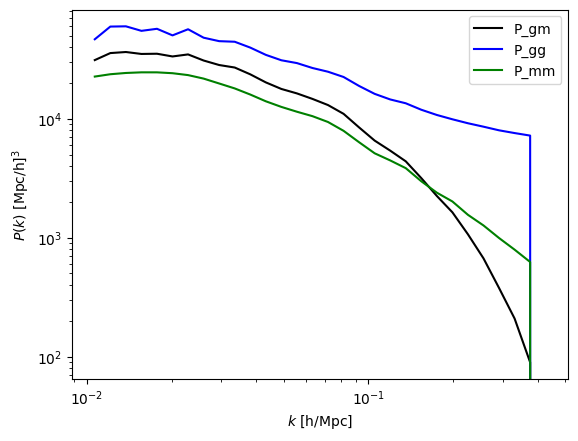

In [20]:
plt.plot(pgm_obj_shame['k'], pgm_obj_shame['pk'], label='P_gm', color='black')
plt.plot(pk_obj_shame['k'], pk_obj_shame['pk'], label=f'P_gg', color='blue')
plt.plot(pmm_obj_shame['k'], pmm_obj_shame['pk'], label='P_mm', color='green')
plt.legend()
plt.xlabel(r'$k$ [h/Mpc]')
plt.ylabel(r'$P(k)$ [Mpc/h]$^3$')
plt.xscale('log')
plt.yscale('log')
plt.show()

# Load and plot

In [21]:
data_mode = 'muchisimocks'
statistics = ['pk', 'pgm']
#statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_unit_p5_n10000'
# tag_Anoise = '_Anmult_p5_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
#tag_noise = '_noise_unit_test_p5_n1000'
#tag_Anoise = '_Anmult_p5_n1000'
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
tag_noise = None
tag_Anoise = None
tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
if tag_noise is None:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
else:
    tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_noise + tag_Anoise + tag_datagen
k_arr, y_arr, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000
Loaded pk data with shape (1000, 30)
fn_mask: ../data/masks/mask_pk_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_pk_muchisimocks_pk_pgm_test_p5_n1000_biaszen_p4_n1000.txt (already exists)
Masked 1 out of 30 bins
(29,) (1000, 29) (1000, 29)
dir_statistics: /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Found 1000 diff cosmo pgms in /scratch/kstoreyf/muchisimocks/data/pgms_mlib/pgms_test_p5_n1000_biaszen_p4_n1000
Loaded pgm data with shape (1000, 30)
fn_mask: ../data/masks/mask_pgm_muchisimocks_pk_pgm_test_p5_n1000_bias

In [22]:
theta, param_names = data_loader.param_dfs_to_theta(idxs_params, params_df, biasparams_df, Anoise_df=Anoise_df)

In [23]:
# unpack the stats
k_pk = k_arr[statistics.index('pk')]
y_pk = y_arr[statistics.index('pk')]

k_pgm = k_arr[statistics.index('pgm')]
y_pgm = y_arr[statistics.index('pgm')]

# k_bispec = k_arr[statistics.index('bispec')]
# y_bispec = y_arr[statistics.index('bispec')]


In [34]:
### load shame
statistic = 'pgm'
fn_stat = f'../data/data_shame/data_nbar0.00022/{statistic}s/{statistic}.npy'
pgm_obj_shame_mean = np.load(fn_stat, allow_pickle=True).item()

statistic = 'pk'
fn_stat = f'../data/data_shame/data_nbar0.00022/{statistic}s/{statistic}.npy'
pk_obj_shame_mean = np.load(fn_stat, allow_pickle=True).item()

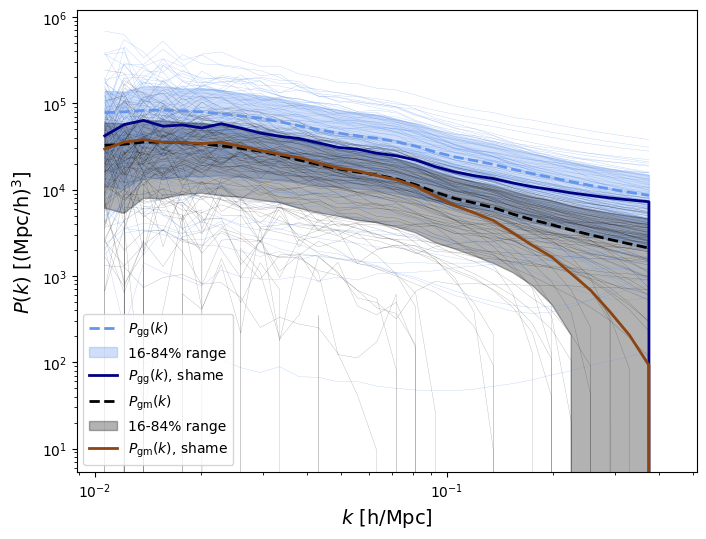

In [37]:

plt.figure(figsize=(8,6))

n_plot = np.min([100, y_pk.shape[0]])
first = True
for i in range(n_plot):
    label = None
    plt.plot(k_pk, y_pk[i], color='cornflowerblue', alpha=0.6, lw=0.2, label=label)
    plt.plot(k_pgm, y_pgm[i], color='black', alpha=0.4, lw=0.2, label=label)

## P(k)
mean = np.mean(y_pk, axis=0)
p16 = np.percentile(y_pk, 16, axis=0)
p84 = np.percentile(y_pk, 84, axis=0)
plt.plot(k_pk, mean, color='cornflowerblue', lw=2, ls='--', label=r'$P_{\rm gg}(k)$')
plt.fill_between(k_pk, p16, p84, color='cornflowerblue', alpha=0.3, label=r'16-84% range')

plt.plot(pk_obj_shame_mean['k'], pk_obj_shame_mean['pk'], color='navy', lw=2, ls='-', label=r'$P_{\rm gg}(k)$, shame')

## P_gm
mean = np.mean(y_pgm, axis=0)
p16 = np.percentile(y_pgm, 16, axis=0)
p84 = np.percentile(y_pgm, 84, axis=0)
plt.plot(k_pgm, mean, color='black', lw=2, ls='--', label=r'$P_{\rm gm}(k)$')
plt.fill_between(k_pgm, p16, p84, color='black', alpha=0.3, label=r'16-84% range')

plt.plot(pgm_obj_shame_mean['k'], pgm_obj_shame_mean['pk'], color='saddlebrown', lw=2, ls='-', label=r'$P_{\rm gm}(k)$, shame')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)

plt.legend(fontsize=10)